In [12]:
# Created Jan 9, 2022
# Updated Jan 9, 2022

import sys
sys.path.append('../')

import sys; sys.path.insert(0, '../../') ## make sure path to root of project directory
from wu_barcodes.config import *
from data.wu_data import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import methods.ax_methods as ax_methods
mpl.rcParams.update(mpl_configs)
import numpy as np; rnd = np.random.default_rng()
import scipy.stats

import pickle

In [13]:
import methods.filter_lineages as fl

import scipy.ndimage.filters as ndif
def running_mean_uniform_filter1d(x, N):
    return ndif.uniform_filter1d(x, N, mode='reflect', origin=0)

def heat_map(ax, bac, m1, m2, day, day0_read_range):
    print('*** Plotting joint distribution of reads ***')
    row_ids = fl.bac_row_ids[bac]
    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]

    d0_reads = read_array[0]

    m1_reads = np.copy( read_array[ row_ids[(m1, day)] ] )
    m2_reads = np.copy( read_array[ row_ids[(m2, day)] ] )

    print(f'Seq. Depths of Mice={(m1_reads.sum(), m2_reads.sum())}')

    day0_min, day0_max = day0_read_range
    lineage_indices = (d0_reads >= day0_min) * (d0_reads < day0_max) #* (m1_d4_reads > 0) * (m2_d4_reads > 0)
    print(f'# lineages={lineage_indices.sum()}')

    ## plot empirical
    binspace = np.linspace(0, 80, 81)
    ax.hist2d(m1_reads[lineage_indices], m2_reads[lineage_indices], bins=binspace, norm=mpl.colors.LogNorm(0.1, 100), cmap=mpl.cm.Oranges)
    r, pval = scipy.stats.pearsonr(m1_reads[lineage_indices], m2_reads[lineage_indices])
    print(f'r, pval = {r:.2f}, {pval:.1e}')

    ax.set_xlabel('mouse {} day 4 reads'.format(m1))
    ax.set_ylabel('mouse {} day 4 reads'.format(m2))

    ax.set_xlim(0, 80)
    ax.set_ylim(0, 80)
    ax.axvspan( day0_min * m1_reads.sum() / d0_reads.sum(), day0_max * m1_reads.sum() / d0_reads.sum(), color='grey', alpha=0.5, zorder=0)
    ax.axhspan( day0_min * m2_reads.sum() / d0_reads.sum(), day0_max * m2_reads.sum() / d0_reads.sum(), color='grey', alpha=0.5, zorder=0)
    ax.plot( ax.get_xlim(), np.array(ax.get_xlim()) * m2_reads.sum()/m1_reads.sum(), color='black', linestyle='dashed')

def calc_coarse_grained_lfc_array(freqs0, D0, freqs1, D1, dt, coarse_grain=100):
    cg_freqs0 = running_mean_uniform_filter1d(freqs0, coarse_grain)
    cg_freqs1 = running_mean_uniform_filter1d(freqs1, coarse_grain)

    cg_f0, cg_f1 = fl.maxmin_freqs(cg_freqs0, D0, cg_freqs1, D1)

    with np.errstate(divide='ignore'):
        return np.log( cg_f1/cg_f0 ) / dt

with open('../figure1_muller_and_transition/10biggest_indices.pkl', 'rb') as f:
    muller_lineage_dict = pickle.load(f)

/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_33208/1988474347.py:144: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_rank_order.set_xticklabels(xtick_labels)
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_33208/1988474347.py:144: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_rank_order.set_xticklabels(xtick_labels)
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_33208/1988474347.py:144: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_rank_order.set_x

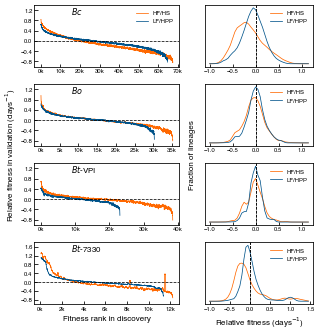

In [14]:
import sklearn.isotonic as isotonic
RANK_ORDER_FORMATS = {'BWH2': (20000, [1000, 5000, 10000, 15000, 19000], ['1k', '5k', '10k', '15k', '19k']),
                      'Bovatus': (10000, [1000, 3000, 5000, 7000, 9000], ['1k', '3k', '5k', '7k', '9k']),
                      'BtVPI': (10000, [1000, 3000, 5000, 7000, 9000], ['1k', '3k', '5k', '7k', '9k']),
                      'Bt7330': (5000, [500, 1500, 2500, 3500, 4500], ['500', '1500', '2500', '3500', '4500'])}

fig = plt.figure(figsize=(5,5.5))
outer = mpl.gridspec.GridSpec(nrows=7, ncols=2, height_ratios=[1, 0.05, 1, 0.05, 1, 0.05, 1],
                              width_ratios=[1, 0.75], figure=fig)


rank_ax = fig.add_subplot(outer[:, 0])
rank_ax.set_xlabel('Fitness rank in discovery', fontsize=8, labelpad=4)
rank_ax.set_ylabel('Relative fitness in validation (days$^{-1}$)', fontsize=8, labelpad=6)
ax_methods.turn_off_ax(rank_ax)

dfe_ax = fig.add_subplot(outer[:, 1])
dfe_ax.set_xlabel('Relative fitness (days$^{-1}$)', fontsize=8, labelpad=4)
dfe_ax.set_ylabel('Fraction of lineages', fontsize=8, labelpad=-2)
ax_methods.turn_off_ax(dfe_ax)

diet_colors = {'HF/HS':DIET_COLORS['HF'], 'LF/HPP':DIET_COLORS['LF']}

for b, bac in enumerate(['BWH2', 'Bovatus', 'BtVPI', 'Bt7330']):
    ax_rank_order = fig.add_subplot(outer[2*b, 0])
    dfe_ax = fig.add_subplot(outer[2*b, 1])
    for (diet, discovery_mice, validation_mice) in [('HF/HS', [6,7,8,9,10], [1,2,3,5]), ('LF/HPP', [11,12,13,15], [16,18,19])]:
        if 'plot rank order curves, etc':
            min_reads = 5
            gene_nn = False
            cutoff = 10**-6.5
            # cutoff = 0
            cg = 100 #coarse_grain

            discovery_d0, discovery_d1 = 0, 4
            discovery_dt = discovery_d1 - discovery_d0
            validation_d0, validation_d1 = 0, 4
            validation_dt = validation_d1 - validation_d0
            panel_indices = {'BWH2':['$\\bf{(c)}$', '$\\bf{(d)}$', '$\\bf{(e)}$'],
                         'BtVPI':['$\\bf{(f)}$', '$\\bf{(g)}$', '$\\bf{(h)}$'],
                         'Bovatus':['$\\bf{(f)}$', '$\\bf{(g)}$', '$\\bf{(h)}$'],
                             'Bt7330':['$\\bf{(f)}$', '$\\bf{(g)}$', '$\\bf{(h)}$']}

        if 'generate discovery and validation frequencies':
            discovery_reads0, discovery_reads1 = np.copy(fl.get_read_arrays(bac, discovery_mice, 0, 4, split_day0=2))
            validation_reads0, validation_reads1 = np.copy(fl.get_read_arrays(bac, validation_mice, 0, 4, split_day0=1))
            # discovery_reads0 -= fl.bac_input_arrays[bac][6][fl.bac_nonwu_indices[bac]]

            discovery_D0, discovery_D1 = discovery_reads0.sum(), discovery_reads1.sum()
            discovery_freqs0, discovery_freqs1 = discovery_reads0 / discovery_D0, discovery_reads1 / discovery_D1

            validation_D0, validation_D1 = validation_reads0.sum(), validation_reads1.sum()
            validation_freqs0, validation_freqs1 = validation_reads0 /validation_D0, validation_reads1 /validation_D1

            d0_reads = fl.bac_read_arrays[bac][0][fl.bac_nonwu_indices[bac]]
            d0_freqs = d0_reads / d0_reads.sum()
            d1_reads = (discovery_reads1 + validation_reads1)

            max_freqs = np.max([discovery_freqs0, discovery_freqs1], axis=0)
            d_valid = fl.filter_lineages(discovery_reads0, discovery_reads1, min_reads=min_reads, threshold=max_freqs)
            v_valid = fl.filter_lineages(validation_reads0, validation_reads1, min_reads=min_reads, threshold=max_freqs)

            filtered_bool =  (d0_freqs > cutoff) * v_valid #* d_valid
            lineage_indices = rnd.permutation( np.arange(d0_freqs.shape[-1])[filtered_bool] )

            d_f0, d_f1 = fl.maxmin_freqs(discovery_freqs0, discovery_D0, discovery_freqs1, discovery_D1)
            v_f0, v_f1 = fl.maxmin_freqs(validation_freqs0, validation_D0, validation_freqs1, validation_D1)
            n_fit = filtered_bool.sum()

        if 'generate sorted fitnesses':
            fit_indices, sorted_fitnesses = fl.rank_barcodes(d_f0[lineage_indices], d_f1[lineage_indices], discovery_dt)
            fit_indices = lineage_indices[fit_indices]

            # n_fit = filtered_bool.sum()
            v_f0_fit, v_f1_fit = v_f0[fit_indices][:n_fit], v_f1[fit_indices][:n_fit]
            d_freqs0_fit, d_freqs1_fit = discovery_freqs0[fit_indices][:n_fit], discovery_freqs1[fit_indices][:n_fit]
            v_freqs0_fit, v_freqs1_fit = validation_freqs0[fit_indices][:n_fit], validation_freqs1[fit_indices][:n_fit]
            validation_lfcs = fl.calc_lfc_array(v_f0_fit, v_f1_fit, validation_dt)

            cg_validate_lfcs = calc_coarse_grained_lfc_array(v_freqs0_fit, validation_D0, v_freqs1_fit, validation_D1,
                                                             validation_dt, coarse_grain=cg)
            gene_complement_f0, gene_complement_f1 = fl.calc_gene_complement_freqs(bac, fit_indices[:n_fit], validation_freqs0, validation_freqs1, nearest_neighbors=gene_nn, cutoff=cutoff)
            cg_gene_complement_lfcs = calc_coarse_grained_lfc_array(gene_complement_f0, validation_D0, gene_complement_f1, validation_D1,
                                                                    validation_dt, coarse_grain=cg)

        if diet in ['HF/HS', 'LF/HPP']:
            if 'rank order plot':
                # ax_rank_order.plot(np.arange(n_fit), sorted_fitnesses[:n_fit], KELLY_COLORS[4], label="discovery fitness")
                # ax_rank_order.scatter(np.arange(validation_lfcs.shape[-1]), validation_lfcs, s=1, color=KELLY_COLORS[3], rasterized=True, zorder=0, alpha=0.1)
                ax_rank_order.plot(np.arange(cg_validate_lfcs.shape[-1])[cg//2:-cg//2],
                                    cg_validate_lfcs[cg//2:-cg//2], color=diet_colors[diet], label=f'{diet}')
                # ax_rank_order.plot(np.arange(cg_gene_complement_lfcs.shape[-1])[cg//2:-cg//2],
                #                     cg_gene_complement_lfcs[cg//2:-cg//2], KELLY_COLORS[1], zorder=0, label="gene complement")


        fitnesses = cg_validate_lfcs[50:-50][::-1]
        ranks = np.arange(fitnesses.shape[0])
        # ax.plot(fitnesses, ranks[::-1])
        dx = 0.05
        if bac == 'Bt7330':
            x = np.arange(-1.0, 1.5, dx)
        else:
            x = np.arange(-1.0, 1.2, dx )
        x_avg = (x[1:]+x[:-1])/2

        # # iso_reg = isotonic.IsotonicRegression().fit(fitnesses, ranks[::-1])
        # # cdf = iso_reg.predict(x) # # # print(iso_y[10:])
        # # dfe = (cdf[1:]-cdf[:-1]) / dx
        # # # ax.plot(x_avg, dfe, color=KELLY_COLORS[b], linestyle='dotted')
        #
        # iso_reg = isotonic.IsotonicRegression().fit(ranks, fitnesses)
        # iso_y = iso_reg.predict(ranks) # # # print(iso_y[10:])
        #
        # iso_y += rnd.normal(scale=1e-5, size=iso_y.shape[0])
        # sort = np.argsort(iso_y)
        # c3_spline = scipy.interpolate.PchipInterpolator(iso_y[sort], ranks[sort])
        # cdf = c3_spline(x)
        # deriv = c3_spline.derivative(1)
        # dfe = (cdf[1:]-cdf[:-1]) / dx
        # # ax.plot(x_avg, dfe, color='black', linestyle='dotted')
        # # ax.plot(x_avg, deriv(x_avg), color=KELLY_COLORS[b], linestyle='dotted')

        kernel = scipy.stats.gaussian_kde(fitnesses, bw_method=0.2)

        dfe_ax.plot(x, kernel(x), label=f'{diet}', color=diet_colors[diet])
        dfe_ax.set_yticks([])
        dfe_ax.axvline(0, color='black', linestyle='dashed')
        dfe_ax.legend(frameon=False)
        # dfe_ax.set_xlabel('relative fitness (/day)')
        # dfe_ax.set_ylabel('density')
    if 'format rank order plot':
            _, xticks, xtick_labels = RANK_ORDER_FORMATS[bac]
            # ax_rank_order.set_xticks(xticks)
            # ax_rank_order.set_xticklabels(xtick_labels)
            # ax_rank_order.set_xlim(-n_fit/100, n_fit)
            ax_rank_order.set_ylim(-1.0, 1.4)
            y_ticks = [-0.8, -0.4, 0, 0.4, 0.8, 1.2]
            if bac == 'Bt7330':
                ax_rank_order.set_ylim(-1.0, 1.8)
                y_ticks = [-0.8, -0.4, 0, 0.4, 0.8, 1.2, 1.6]
            x_ticks = ax_rank_order.get_xticks()
            x_ticks = [1] + list(x_ticks[1:])
            xtick_labels = [1]+[str(int(xtick/1000))+'k' for xtick in x_ticks[1:]]
            ax_rank_order.set_xticklabels(xtick_labels)
            ax_rank_order.set_yticks(y_ticks, fontsize=40)
            ax_rank_order.axhline(0, color='black', linestyle='dashed')
            ax_rank_order.text(0.25, 0.85, f'{BAC_FORMAL_NAMES[bac]}', transform=ax_rank_order.transAxes)
            if bac == 'BWH2':
                    # legend_markers = [ax_methods.make_marker_obj(color=KELLY_COLORS[4]),
                    #                   ax_methods.make_marker_obj(color=KELLY_COLORS[9], marker='o', mec=KELLY_COLORS[3], mfc=KELLY_COLORS[3], markersize=3.5)]
                    # ax_rank_order.legend(legend_markers, ['discovery', 'validation'], fontsize=6, loc=1)
                    ax_rank_order.legend(frameon=False)
                # ax_rank_order.set_xlabel('fitness rank order in discovery')
                # ax_rank_order.set_ylabel('relative fitness (/day)')

fig.savefig(f'{biorxiv}/SI_full_rank_order_and_dfe.pdf')

# with open('day04_sorted_indices.pkl', 'wb') as f:
#     pickle.dump(sorted_indices_dict, f)

In [67]:
# fig, ax = plt.subplots()
# # ax.plot( discovery_reads0[fit_indices[:5000]]/validation_reads0[fit_indices[:5000]])
# ax.set_yscale('log')
#
# ax.plot( discovery_reads0[fit_indices[2000:3000]])
# ax.plot(validation_reads0[fit_indices[2000:3000]])
# ax.set_ylim(1, 20)

In [24]:
# bac = 'Bt7330'
# for i in range(1, 23):
#     Ri = bac_input_arrays[bac][i]
#     for j in range(i+1, 24):
#         Rj = bac_input_arrays[bac][j]
#         fig, ax = plt.subplots()
#         ax.scatter(Ri, Rj, rasterized=True)
#         ax.set_xscale('log')
#         ax.set_yscale('log')
#         ax.set_title(f'{i}, {j}')